In [1]:
import glob
import torch
import pandas as pd
from tqdm import tqdm
from pycocotools.coco import COCO

from rfdetr import RFDETRMedium 

from ensemble_boxes import soft_nms


In [2]:
class_name={0:"General trash", 1:"Paper", 2:"Paper pack", 3:"Metal", 4:"Glass", 5:"Plastic", 6:"Styrofoam", 7:"Plastic bag", 8:"Battery", 9:"Clothing"}
class_colors = {
    "0": (255, 0, 0),
    "1": (0, 255, 0),
    "2": (0, 0, 255),
    "3": (255, 255, 0),
    "4": (255, 0, 255),
    "5": (0, 255, 255),
    "6": (128, 0, 128),
    "7": (128, 128, 0),
    "8": (0, 128, 128),
    "9": (0, 128, 255),
}

In [77]:
def batch_predict_and_export(
    annotation_path,
    image_dir,
    checkpoint,
    output_csv="./output.csv",
    batch_size=16,
    threshold=0.0
):

    coco = COCO(annotation_path)
    img_infos = coco.loadImgs(coco.getImgIds())

    image_paths = [f"{image_dir}/{img['file_name']}" for img in img_infos]

    model = RFDETRMedium(pretrain_weights=checkpoint,resolution=768,multi_scale=True)
    # model.optimize_for_inference()
    final_predictions = []
    final_filenames = []


    for i in tqdm(range(0, len(image_paths), batch_size)):
        batch = image_paths[i:i + batch_size]

        preds = model.predict(batch, threshold=threshold)
        # print(preds)
        
        if not isinstance(preds, list):
            preds = [preds]

        for img_path, det in zip(batch, preds):

            pred_str = ""
            boxes = det.xyxy
            scores = det.confidence
            labels = det.class_id

            for box, score, label in zip(boxes, scores, labels):
                if score >= threshold:
                    x1, y1, x2, y2 = box
                    pred_str += f"{label} {score:.4f} {x1:.2f} {y1:.2f} {x2:.2f} {y2:.2f} "

            final_predictions.append(pred_str)

            img_path_split=img_path.split("/")
            final_filenames.append(img_path_split[-2]+'/'+img_path_split[-1])

    submission = pd.DataFrame({
        "PredictionString": final_predictions,
        "image_id": final_filenames
    })

    submission.to_csv(output_csv, index=False)
    print("저장 완료:", output_csv)
    print(submission.head())





In [78]:

batch_predict_and_export(
    annotation_path="../../../dataset_for_RFDETR/test/_annotations.coco.json",
    image_dir="../../../dataset_for_RFDETR/test",   # test 이미지 경로
    checkpoint="./RF_DETR_ckpt/checkpoint_best_ema.pth",
    output_csv="./output.csv",
    batch_size=16,
    threshold=0.01
)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


100%|█████████████████████████████████████████████████████████████████████████████████| 305/305 [02:43<00:00,  1.87it/s]


저장 완료: ./output.csv
                                    PredictionString       image_id
0  7 0.9844 603.23 518.17 956.03 1022.77 7 0.9760...  test/0000.jpg
1  5 0.6170 130.83 0.17 492.89 271.15 4 0.4602 34...  test/0001.jpg
2  1 0.9474 78.90 273.42 424.65 602.38 1 0.9394 7...  test/0002.jpg
3  9 0.9851 149.55 264.12 910.05 824.47 9 0.2958 ...  test/0003.jpg
4  1 0.9582 195.46 254.67 873.75 780.53 0 0.5820 ...  test/0004.jpg


# TTA

In [10]:
# import cv2
# import numpy as np
# from ensemble_boxes import soft_nms


# def run_tta_softnms(
#     model,
#     img_path,
#     scales=[0.5, 1.0, 1.5],
#     threshold=0.05,
#     soft_iou=0.8,
#     soft_sigma=0.5,
#     flip=False,
# ):
#     img = cv2.imread(img_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     h, w = img.shape[:2]

#     all_boxes = []
#     all_scores = []
#     all_labels = [] 

#     for scale in scales:
#         new_w, new_h = int(w * scale), int(h * scale)
#         resized = cv2.resize(img, (new_w, new_h))

#         det = model.predict(resized, threshold=0.001)
#         if isinstance(det, list):
#             det = det[0]

#         boxes = det.xyxy
#         scores = det.confidence
#         labels = det.class_id

#         for box, score, label in zip(boxes, scores, labels):
#             if score < threshold:
#                 continue

#             x1, y1, x2, y2 = box

#             # 원본 scale 복귀
#             x1 *= (w / new_w)
#             x2 *= (w / new_w)
#             y1 *= (h / new_h)
#             y2 *= (h / new_h)

#             # pixel clip
#             x1 = max(0, min(x1, w))
#             x2 = max(0, min(x2, w))
#             y1 = max(0, min(y1, h))
#             y2 = max(0, min(y2, h))

#             # normalize
#             nx1, ny1 = x1 / w, y1 / h
#             nx2, ny2 = x2 / w, y2 / h

#             # normalize clip
#             nx1 = max(0.0, min(nx1, 1.0))
#             ny1 = max(0.0, min(ny1, 1.0))
#             nx2 = max(0.0, min(nx2, 1.0))
#             ny2 = max(0.0, min(ny2, 1.0))

#             all_boxes.append([nx1, ny1, nx2, ny2])
#             all_scores.append(float(score))
#             all_labels.append(int(label))

#         # flip 은 원본 scale에서만
#         if flip and abs(scale - 1.0) < 1e-6:
#             flp = cv2.flip(resized, 1)

#             det_f = model.predict(flp, threshold=0.001)
#             if isinstance(det_f, list):
#                 det_f = det_f[0]

#             boxes_f = det_f.xyxy
#             scores_f = det_f.confidence
#             labels_f = det_f.class_id

#             for box, score, label in zip(boxes_f, scores_f, labels_f):
#                 if score < threshold:
#                     continue

#                 x1, y1, x2, y2 = box

#                 # flip 복원 (resized 기준)
#                 fx1 = new_w - x2
#                 fx2 = new_w - x1

#                 # 원본 scale 복귀
#                 fx1 *= (w / new_w)
#                 fx2 *= (w / new_w)
#                 y1  *= (h / new_h)
#                 y2  *= (h / new_h)

#                 # pixel clip
#                 fx1 = max(0, min(fx1, w))
#                 fx2 = max(0, min(fx2, w))
#                 y1  = max(0, min(y1,  h))
#                 y2  = max(0, min(y2,  h))

#                 # normalize
#                 nnx1, nny1 = fx1 / w, y1 / h
#                 nnx2, nny2 = fx2 / w, y2 / h

#                 # normalize clip
#                 nnx1 = max(0.0, min(nnx1, 1.0))
#                 nny1 = max(0.0, min(nny1, 1.0))
#                 nnx2 = max(0.0, min(nnx2, 1.0))
#                 nny2 = max(0.0, min(nny2, 1.0))

#                 all_boxes.append([nnx1, nny1, nnx2, nny2])
#                 all_scores.append(float(score))
#                 all_labels.append(int(label))

#     if len(all_boxes) == 0:
#         return []
#     print(len(all_boxes))
#     return
#     # soft_nms 는 [boxes], [scores], [labels] 형태(모델 개수 차원)로 받음
#     merged_boxes, merged_scores, merged_labels = soft_nms(
#         [all_boxes],
#         [all_scores],
#         [all_labels],
#         iou_thr=soft_iou,
#         sigma=soft_sigma,
#         thresh=threshold,
#     )

#     results = []
#     for (x1, y1, x2, y2), score, label in zip(merged_boxes, merged_scores, merged_labels):
#         results.append([
#             x1 * w, y1 * h, x2 * w, y2 * h,
#             score, int(label)
#         ])

#     return results

In [7]:
import cv2
import numpy as np
from ensemble_boxes import soft_nms,weighted_boxes_fusion


def run_tta_softnms(
    model,
    img_path,
    scales=[0.5, 1.0, 1.5],
    threshold=0.05,
    soft_iou=0.7,
    soft_sigma=0.5,
    flip=True,
):
    # 이미지 읽기
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    # TTA별 박스/스코어/라벨 리스트 (모델 차원)
    tta_boxes_list = []  
    tta_scores_list = [] 
    tta_labels_list = []

    for scale in scales:
        new_w, new_h = int(w * scale), int(h * scale)
        resized = cv2.resize(img, (new_w, new_h))

        det = model.predict(resized, threshold=0.001)
        if isinstance(det, list):
            det = det[0]

        boxes = det.xyxy
        scores = det.confidence
        labels = det.class_id

        # 이 scale 에 대한 TTA 결과
        boxes_tta = []
        scores_tta = []
        labels_tta = []

        for box, score, label in zip(boxes, scores, labels):
            if score < threshold:
                continue

            x1, y1, x2, y2 = box

            # 원본 scale 복귀
            x1 *= (w / new_w)
            x2 *= (w / new_w)
            y1 *= (h / new_h)
            y2 *= (h / new_h)

            # pixel clip
            x1 = max(0, min(x1, w))
            x2 = max(0, min(x2, w))
            y1 = max(0, min(y1, h))
            y2 = max(0, min(y2, h))

            # normalize (soft_nms/wbf는 [0,1] 좌표 사용)
            nx1, ny1 = x1 / w, y1 / h
            nx2, ny2 = x2 / w, y2 / h

            # normalize clip
            nx1 = max(0.0, min(nx1, 1.0))
            ny1 = max(0.0, min(ny1, 1.0))
            nx2 = max(0.0, min(nx2, 1.0))
            ny2 = max(0.0, min(ny2, 1.0))

            boxes_tta.append([nx1, ny1, nx2, ny2])
            scores_tta.append(float(score))
            labels_tta.append(int(label))

        # 이 scale 에서 나온 박스가 있다면 TTA 리스트에 추가
        if len(boxes_tta) > 0:
            tta_boxes_list.append(boxes_tta)
            tta_scores_list.append(scores_tta)
            tta_labels_list.append(labels_tta)

        # flip 은 원본 scale에서만 (scale == 1.0 부근)
        if flip and abs(scale - 1.0) < 1e-6:
            flp = cv2.flip(resized, 1)

            det_f = model.predict(flp, threshold=0.001)
            if isinstance(det_f, list):
                det_f = det_f[0]

            boxes_f = det_f.xyxy
            scores_f = det_f.confidence
            labels_f = det_f.class_id

            boxes_flip = []
            scores_flip = []
            labels_flip = []

            for box, score, label in zip(boxes_f, scores_f, labels_f):
                if score < threshold:
                    continue

                x1, y1, x2, y2 = box

                # flip 복원 (resized 기준)
                fx1 = new_w - x2
                fx2 = new_w - x1

                # 원본 scale 복귀
                fx1 *= (w / new_w)
                fx2 *= (w / new_w)
                y1  *= (h / new_h)
                y2  *= (h / new_h)

                # pixel clip
                fx1 = max(0, min(fx1, w))
                fx2 = max(0, min(fx2, w))
                y1  = max(0, min(y1,  h))
                y2  = max(0, min(y2,  h))

                # normalize
                nnx1, nny1 = fx1 / w, y1 / h
                nnx2, nny2 = fx2 / w, y2 / h

                # normalize clip
                nnx1 = max(0.0, min(nnx1, 1.0))
                nny1 = max(0.0, min(nny1, 1.0))
                nnx2 = max(0.0, min(nnx2, 1.0))
                nny2 = max(0.0, min(nny2, 1.0))

                boxes_flip.append([nnx1, nny1, nnx2, nny2])
                scores_flip.append(float(score))
                labels_flip.append(int(label))

            if len(boxes_flip) > 0:
                tta_boxes_list.append(boxes_flip)
                tta_scores_list.append(scores_flip)
                tta_labels_list.append(labels_flip)

    # 모든 TTA에서 박스가 하나도 안 나왔다면
    if len(tta_boxes_list) == 0:
        return []

    # soft_nms 는 [TTA개수][N][4] 구조를 받음
    merged_boxes, merged_scores, merged_labels = soft_nms(
        tta_boxes_list,
        tta_scores_list,
        tta_labels_list,
        iou_thr=soft_iou,
        sigma=soft_sigma,
        thresh=threshold,
    )
    # print(len(tta_boxes_list),len(tta_scores_list),len(tta_labels_list))
    # merged_boxes, merged_scores, merged_labels = weighted_box_fusion(
    #     tta_boxes_list,
    #     tta_scores_list,
    #     tta_labels_list,
    #     weight=[1,1,1],
    #     iou_thr=soft_iou,
    #     skip_box_thr=threshold,
    # )

    # 결과를 원본 이미지 픽셀 좌표로 복원
    results = []
    for (x1, y1, x2, y2), score, label in zip(merged_boxes, merged_scores, merged_labels):
        results.append([
            x1 * w, y1 * h, x2 * w, y2 * h,
            float(score), int(label)
        ])

    return results

In [8]:
def export_tta_softnms_csv(
    annotation_path,
    image_dir,
    checkpoint,
    output_csv="./tta_submission.csv",
    scales=[1.0],
    threshold=0.05,
    flip=False,
    
):
    coco = COCO(annotation_path)
    img_infos = coco.loadImgs(coco.getImgIds())

    model = RFDETRMedium(pretrain_weights=checkpoint,resolution=768,multi_scale=True)

    final_preds = []
    final_files = []

    for info in tqdm(img_infos):
        img_path = f"{image_dir}/{info['file_name']}"

        merged_results = run_tta_softnms(
            model,
            img_path,
            scales=scales,
            threshold=threshold,
            flip=flip,
        )

        pred_str = ""
        for x1, y1, x2, y2, score, cls in merged_results:
            pred_str += f"{cls} {score:.4f} {x1:.2f} {y1:.2f} {x2:.2f} {y2:.2f} "

        final_preds.append(pred_str.strip())
        final_files.append(info["file_name"])

    pd.DataFrame({
        "PredictionString": final_preds,
        "image_id": final_files
    }).to_csv(output_csv, index=False)

    print("저장 완료:", output_csv)

In [9]:
export_tta_softnms_csv(
    annotation_path="../../../dataset_for_RFDETR/test/_annotations.coco.json",
    image_dir="../../../dataset_for_RFDETR/test",   # test 이미지 경로
    checkpoint="./RF_DETR_ckpt/checkpoint_best_ema.pth",
    output_csv="./output_TTA.csv",
    scales=[0.8,1.0,1.5],
    threshold=0.01,
    flip=True,
)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


  0%|                                                                                  | 4/4871 [00:00<20:24,  3.97it/s]

Warning. Removed 1 boxes with zero area!


  0%|▏                                                                                | 10/4871 [00:02<18:08,  4.46it/s]

Warning. Removed 1 boxes with zero area!


  1%|▉                                                                                | 58/4871 [00:12<16:48,  4.77it/s]

Warning. Removed 4 boxes with zero area!


  2%|█▎                                                                               | 78/4871 [00:17<20:08,  3.97it/s]

Warning. Removed 6 boxes with zero area!


  2%|█▋                                                                              | 105/4871 [00:24<20:40,  3.84it/s]

Warning. Removed 1 boxes with zero area!


  2%|█▊                                                                              | 112/4871 [00:25<18:12,  4.35it/s]

Warning. Removed 2 boxes with zero area!


  3%|██▏                                                                             | 136/4871 [00:31<16:38,  4.74it/s]

Warning. Removed 1 boxes with zero area!


  3%|██▍                                                                             | 147/4871 [00:33<16:35,  4.74it/s]

Warning. Removed 1 boxes with zero area!


  4%|███▏                                                                            | 197/4871 [00:44<18:04,  4.31it/s]

Warning. Removed 3 boxes with zero area!


  4%|███▍                                                                            | 210/4871 [00:47<17:11,  4.52it/s]

Warning. Removed 10 boxes with zero area!
Warning. Removed 1 boxes with zero area!


  4%|███▌                                                                            | 218/4871 [00:49<15:46,  4.92it/s]

Warning. Removed 1 boxes with zero area!


  5%|████▏                                                                           | 258/4871 [00:57<15:14,  5.05it/s]

Warning. Removed 1 boxes with zero area!


  6%|████▌                                                                           | 277/4871 [01:01<17:35,  4.35it/s]

Warning. Removed 1 boxes with zero area!


  6%|████▋                                                                           | 289/4871 [01:04<16:40,  4.58it/s]

Warning. Removed 1 boxes with zero area!


  6%|█████▏                                                                          | 314/4871 [01:09<15:23,  4.93it/s]

Warning. Removed 2 boxes with zero area!


  6%|█████▏                                                                          | 316/4871 [01:09<15:25,  4.92it/s]

Warning. Removed 8 boxes with zero area!


  7%|█████▌                                                                          | 336/4871 [01:13<14:27,  5.23it/s]

Warning. Removed 1 boxes with zero area!


  7%|█████▉                                                                          | 361/4871 [01:18<15:51,  4.74it/s]

Warning. Removed 6 boxes with zero area!


  7%|█████▉                                                                          | 362/4871 [01:19<15:20,  4.90it/s]

Warning. Removed 1 boxes with zero area!


  8%|██████▍                                                                         | 393/4871 [01:25<15:29,  4.82it/s]

Warning. Removed 1 boxes with zero area!


  8%|██████▌                                                                         | 396/4871 [01:26<15:26,  4.83it/s]

Warning. Removed 1 boxes with zero area!


  8%|██████▋                                                                         | 406/4871 [01:28<15:44,  4.73it/s]

Warning. Removed 2 boxes with zero area!


  9%|███████▏                                                                        | 438/4871 [01:34<15:07,  4.89it/s]

Warning. Removed 4 boxes with zero area!


  9%|███████▏                                                                        | 439/4871 [01:35<15:09,  4.87it/s]

Warning. Removed 1 boxes with zero area!


 10%|███████▊                                                                        | 475/4871 [01:42<15:41,  4.67it/s]

Warning. Removed 3 boxes with zero area!


 11%|████████▍                                                                       | 513/4871 [01:50<13:17,  5.46it/s]

Warning. Removed 3 boxes with zero area!


 11%|████████▋                                                                       | 532/4871 [01:54<14:29,  4.99it/s]

Warning. Removed 1 boxes with zero area!


 12%|█████████▎                                                                      | 566/4871 [02:01<14:27,  4.96it/s]

Warning. Removed 2 boxes with zero area!


 12%|█████████▌                                                                      | 581/4871 [02:04<16:06,  4.44it/s]

Warning. Removed 4 boxes with zero area!


 12%|█████████▉                                                                      | 605/4871 [02:09<13:38,  5.21it/s]

Warning. Removed 2 boxes with zero area!


 13%|██████████▎                                                                     | 628/4871 [02:13<14:23,  4.91it/s]

Warning. Removed 3 boxes with zero area!


 13%|██████████▌                                                                     | 640/4871 [02:16<14:30,  4.86it/s]

Warning. Removed 1 boxes with zero area!


 13%|██████████▋                                                                     | 652/4871 [02:19<14:44,  4.77it/s]

Warning. Removed 1 boxes with zero area!


 14%|██████████▉                                                                     | 669/4871 [02:22<14:11,  4.93it/s]

Warning. Removed 1 boxes with zero area!


 14%|███████████▍                                                                    | 699/4871 [02:28<13:20,  5.21it/s]

Warning. Removed 2 boxes with zero area!


 15%|███████████▉                                                                    | 724/4871 [02:34<14:07,  4.90it/s]

Warning. Removed 3 boxes with zero area!


 15%|████████████▏                                                                   | 740/4871 [02:37<12:43,  5.41it/s]

Warning. Removed 2 boxes with zero area!


 15%|████████████▏                                                                   | 742/4871 [02:37<13:21,  5.15it/s]

Warning. Removed 12 boxes with zero area!


 17%|█████████████▎                                                                  | 811/4871 [02:52<12:45,  5.30it/s]

Warning. Removed 9 boxes with zero area!


 17%|█████████████▌                                                                  | 826/4871 [02:55<13:52,  4.86it/s]

Warning. Removed 3 boxes with zero area!


 18%|██████████████                                                                  | 855/4871 [03:01<13:04,  5.12it/s]

Warning. Removed 3 boxes with zero area!


 18%|██████████████▎                                                                 | 870/4871 [03:04<13:12,  5.05it/s]

Warning. Removed 1 boxes with zero area!


 18%|██████████████▌                                                                 | 888/4871 [03:08<17:47,  3.73it/s]

Warning. Removed 12 boxes with zero area!


 19%|███████████████▏                                                                | 927/4871 [03:18<16:39,  3.95it/s]

Warning. Removed 1 boxes with zero area!


 19%|███████████████▍                                                                | 942/4871 [03:22<15:51,  4.13it/s]

Warning. Removed 1 boxes with zero area!


 20%|████████████████▏                                                               | 983/4871 [03:32<15:13,  4.26it/s]

Warning. Removed 1 boxes with zero area!


 20%|████████████████▏                                                               | 986/4871 [03:33<13:08,  4.93it/s]

Warning. Removed 3 boxes with zero area!


 21%|████████████████▌                                                              | 1024/4871 [03:42<15:39,  4.09it/s]

Warning. Removed 2 boxes with zero area!


 21%|████████████████▌                                                              | 1025/4871 [03:42<15:50,  4.04it/s]

Warning. Removed 2 boxes with zero area!


 21%|████████████████▋                                                              | 1026/4871 [03:42<16:26,  3.90it/s]

Warning. Removed 2 boxes with zero area!


 21%|████████████████▉                                                              | 1042/4871 [03:46<16:04,  3.97it/s]

Warning. Removed 1 boxes with zero area!


 22%|█████████████████                                                              | 1052/4871 [03:49<14:30,  4.39it/s]

Warning. Removed 1 boxes with zero area!


 22%|█████████████████                                                              | 1054/4871 [03:49<14:45,  4.31it/s]

Warning. Removed 1 boxes with zero area!


 22%|█████████████████▏                                                             | 1061/4871 [03:51<16:07,  3.94it/s]

Warning. Removed 2 boxes with zero area!


 23%|█████████████████▉                                                             | 1108/4871 [04:02<13:50,  4.53it/s]

Warning. Removed 1 boxes with zero area!


 23%|██████████████████▏                                                            | 1119/4871 [04:04<12:51,  4.87it/s]

Warning. Removed 5 boxes with zero area!


 23%|██████████████████▍                                                            | 1140/4871 [04:08<12:35,  4.94it/s]

Warning. Removed 4 boxes with zero area!


 24%|██████████████████▋                                                            | 1154/4871 [04:11<12:02,  5.15it/s]

Warning. Removed 5 boxes with zero area!


 24%|██████████████████▊                                                            | 1157/4871 [04:12<12:03,  5.13it/s]

Warning. Removed 1 boxes with zero area!


 24%|███████████████████                                                            | 1174/4871 [04:15<12:01,  5.13it/s]

Warning. Removed 2 boxes with zero area!


 24%|███████████████████▏                                                           | 1181/4871 [04:17<11:15,  5.47it/s]

Warning. Removed 1 boxes with zero area!
Warning. Removed 2 boxes with zero area!


 25%|███████████████████▌                                                           | 1204/4871 [04:21<11:45,  5.19it/s]

Warning. Removed 5 boxes with zero area!


 25%|███████████████████▊                                                           | 1223/4871 [04:25<12:13,  4.97it/s]

Warning. Removed 2 boxes with zero area!


 25%|████████████████████                                                           | 1236/4871 [04:28<12:17,  4.93it/s]

Warning. Removed 2 boxes with zero area!


 26%|████████████████████▎                                                          | 1251/4871 [04:31<12:21,  4.88it/s]

Warning. Removed 2 boxes with zero area!


 26%|████████████████████▍                                                          | 1257/4871 [04:32<12:23,  4.86it/s]

Warning. Removed 8 boxes with zero area!


 26%|████████████████████▊                                                          | 1282/4871 [04:37<12:16,  4.87it/s]

Warning. Removed 5 boxes with zero area!


 26%|████████████████████▉                                                          | 1288/4871 [04:38<11:40,  5.12it/s]

Warning. Removed 1 boxes with zero area!


 27%|█████████████████████                                                          | 1299/4871 [04:41<11:39,  5.11it/s]

Warning. Removed 3 boxes with zero area!


 27%|█████████████████████                                                          | 1300/4871 [04:41<11:50,  5.02it/s]

Warning. Removed 2 boxes with zero area!


 27%|█████████████████████                                                          | 1301/4871 [04:41<11:52,  5.01it/s]

Warning. Removed 2 boxes with zero area!


 28%|██████████████████████                                                         | 1364/4871 [04:54<11:53,  4.91it/s]

Warning. Removed 5 boxes with zero area!


 28%|██████████████████████▏                                                        | 1366/4871 [04:54<12:37,  4.63it/s]

Warning. Removed 2 boxes with zero area!


 29%|███████████████████████                                                        | 1423/4871 [05:06<10:41,  5.38it/s]

Warning. Removed 6 boxes with zero area!


 30%|███████████████████████▋                                                       | 1463/4871 [05:14<11:18,  5.02it/s]

Warning. Removed 5 boxes with zero area!


 30%|███████████████████████▉                                                       | 1475/4871 [05:17<11:27,  4.94it/s]

Warning. Removed 1 boxes with zero area!


 31%|████████████████████████▎                                                      | 1497/4871 [05:21<11:14,  5.00it/s]

Warning. Removed 7 boxes with zero area!


 31%|████████████████████████▍                                                      | 1504/4871 [05:23<11:21,  4.94it/s]

Warning. Removed 9 boxes with zero area!


 32%|█████████████████████████                                                      | 1542/4871 [05:31<12:54,  4.30it/s]

Warning. Removed 2 boxes with zero area!


 32%|█████████████████████████▎                                                     | 1563/4871 [05:35<10:45,  5.13it/s]

Warning. Removed 1 boxes with zero area!


 32%|█████████████████████████▍                                                     | 1568/4871 [05:36<10:43,  5.13it/s]

Warning. Removed 1 boxes with zero area!


 32%|█████████████████████████▍                                                     | 1570/4871 [05:36<12:03,  4.57it/s]

Warning. Removed 1 boxes with zero area!


 32%|█████████████████████████▋                                                     | 1580/4871 [05:39<13:14,  4.14it/s]

Warning. Removed 1 boxes with zero area!


 32%|█████████████████████████▋                                                     | 1581/4871 [05:39<12:30,  4.38it/s]

Warning. Removed 3 boxes with zero area!


 33%|█████████████████████████▉                                                     | 1599/4871 [05:43<13:54,  3.92it/s]

Warning. Removed 3 boxes with zero area!


 33%|█████████████████████████▉                                                     | 1600/4871 [05:43<13:47,  3.95it/s]

Warning. Removed 9 boxes with zero area!


 33%|██████████████████████████▎                                                    | 1622/4871 [05:49<14:05,  3.84it/s]

Warning. Removed 1 boxes with zero area!


 34%|██████████████████████████▌                                                    | 1635/4871 [05:52<13:40,  3.94it/s]

Warning. Removed 3 boxes with zero area!


 34%|██████████████████████████▌                                                    | 1637/4871 [05:53<14:00,  3.85it/s]

Warning. Removed 3 boxes with zero area!


 34%|██████████████████████████▋                                                    | 1644/4871 [05:54<13:11,  4.08it/s]

Warning. Removed 5 boxes with zero area!


 34%|██████████████████████████▋                                                    | 1646/4871 [05:55<13:15,  4.06it/s]

Warning. Removed 8 boxes with zero area!


 34%|██████████████████████████▉                                                    | 1663/4871 [05:59<11:17,  4.74it/s]

Warning. Removed 1 boxes with zero area!


 35%|███████████████████████████▍                                                   | 1689/4871 [06:04<10:59,  4.82it/s]

Warning. Removed 1 boxes with zero area!


 35%|███████████████████████████▌                                                   | 1703/4871 [06:07<10:48,  4.89it/s]

Warning. Removed 6 boxes with zero area!


 35%|███████████████████████████▋                                                   | 1704/4871 [06:08<10:48,  4.88it/s]

Warning. Removed 1 boxes with zero area!


 36%|████████████████████████████▎                                                  | 1746/4871 [06:17<13:17,  3.92it/s]

Warning. Removed 1 boxes with zero area!


 36%|████████████████████████████▌                                                  | 1758/4871 [06:19<10:47,  4.81it/s]

Warning. Removed 7 boxes with zero area!


 36%|████████████████████████████▊                                                  | 1773/4871 [06:22<10:24,  4.96it/s]

Warning. Removed 1 boxes with zero area!


 37%|████████████████████████████▉                                                  | 1782/4871 [06:24<09:41,  5.31it/s]

Warning. Removed 1 boxes with zero area!


 37%|█████████████████████████████                                                  | 1789/4871 [06:25<10:41,  4.80it/s]

Warning. Removed 1 boxes with zero area!


 37%|█████████████████████████████                                                  | 1795/4871 [06:27<10:22,  4.94it/s]

Warning. Removed 2 boxes with zero area!


 37%|█████████████████████████████▎                                                 | 1807/4871 [06:29<10:15,  4.98it/s]

Warning. Removed 2 boxes with zero area!


 37%|█████████████████████████████▌                                                 | 1819/4871 [06:32<10:57,  4.64it/s]

Warning. Removed 1 boxes with zero area!


 38%|██████████████████████████████▏                                                | 1863/4871 [06:41<11:13,  4.47it/s]

Warning. Removed 1 boxes with zero area!


 39%|██████████████████████████████▌                                                | 1884/4871 [06:45<09:29,  5.25it/s]

Warning. Removed 8 boxes with zero area!


 40%|███████████████████████████████▎                                               | 1927/4871 [06:54<09:54,  4.95it/s]

Warning. Removed 2 boxes with zero area!


 40%|███████████████████████████████▍                                               | 1939/4871 [06:56<10:08,  4.82it/s]

Warning. Removed 5 boxes with zero area!


 40%|███████████████████████████████▍                                               | 1940/4871 [06:56<10:05,  4.84it/s]

Warning. Removed 1 boxes with zero area!


 40%|███████████████████████████████▌                                               | 1946/4871 [06:58<09:31,  5.11it/s]

Warning. Removed 6 boxes with zero area!


 40%|███████████████████████████████▌                                               | 1948/4871 [06:58<09:44,  5.00it/s]

Warning. Removed 2 boxes with zero area!


 41%|███████████████████████████████▉                                               | 1973/4871 [07:04<12:09,  3.97it/s]

Warning. Removed 1 boxes with zero area!


 41%|████████████████████████████████                                               | 1980/4871 [07:06<11:46,  4.09it/s]

Warning. Removed 2 boxes with zero area!


 41%|████████████████████████████████▏                                              | 1982/4871 [07:06<12:18,  3.91it/s]

Warning. Removed 11 boxes with zero area!


 41%|████████████████████████████████▎                                              | 1993/4871 [07:09<10:27,  4.58it/s]

Warning. Removed 6 boxes with zero area!


 41%|████████████████████████████████▍                                              | 2001/4871 [07:11<09:46,  4.90it/s]

Warning. Removed 3 boxes with zero area!


 41%|████████████████████████████████▌                                              | 2009/4871 [07:13<12:35,  3.79it/s]

Warning. Removed 7 boxes with zero area!


 41%|████████████████████████████████▌                                              | 2010/4871 [07:13<11:49,  4.03it/s]

Warning. Removed 2 boxes with zero area!


 41%|████████████████████████████████▋                                              | 2014/4871 [07:14<09:59,  4.76it/s]

Warning. Removed 18 boxes with zero area!
Warning. Removed 1 boxes with zero area!


 41%|████████████████████████████████▋                                              | 2019/4871 [07:15<11:20,  4.19it/s]

Warning. Removed 2 boxes with zero area!


 42%|████████████████████████████████▉                                              | 2034/4871 [07:19<11:58,  3.95it/s]

Warning. Removed 2 boxes with zero area!


 42%|█████████████████████████████████                                              | 2037/4871 [07:19<10:55,  4.32it/s]

Warning. Removed 1 boxes with zero area!


 42%|█████████████████████████████████                                              | 2040/4871 [07:20<10:51,  4.34it/s]

Warning. Removed 1 boxes with zero area!


 42%|█████████████████████████████████▏                                             | 2045/4871 [07:21<10:45,  4.38it/s]

Warning. Removed 1 boxes with zero area!


 42%|█████████████████████████████████▍                                             | 2058/4871 [07:24<11:44,  3.99it/s]

Warning. Removed 42 boxes with zero area!


 42%|█████████████████████████████████▍                                             | 2065/4871 [07:26<11:44,  3.98it/s]

Warning. Removed 22 boxes with zero area!


 43%|█████████████████████████████████▊                                             | 2087/4871 [07:31<09:06,  5.10it/s]

Warning. Removed 1 boxes with zero area!


 43%|██████████████████████████████████▏                                            | 2111/4871 [07:36<08:52,  5.19it/s]

Warning. Removed 2 boxes with zero area!
Warning. Removed 7 boxes with zero area!


 44%|██████████████████████████████████▍                                            | 2123/4871 [07:38<09:06,  5.03it/s]

Warning. Removed 2 boxes with zero area!


 44%|██████████████████████████████████▋                                            | 2138/4871 [07:41<08:52,  5.13it/s]

Warning. Removed 4 boxes with zero area!


 44%|██████████████████████████████████▊                                            | 2148/4871 [07:43<10:16,  4.42it/s]

Warning. Removed 3 boxes with zero area!


 45%|███████████████████████████████████▏                                           | 2169/4871 [07:47<08:58,  5.02it/s]

Warning. Removed 1 boxes with zero area!


 45%|███████████████████████████████████▏                                           | 2172/4871 [07:48<09:18,  4.83it/s]

Warning. Removed 1 boxes with zero area!


 45%|███████████████████████████████████▌                                           | 2194/4871 [07:53<09:39,  4.62it/s]

Warning. Removed 19 boxes with zero area!


 45%|███████████████████████████████████▋                                           | 2199/4871 [07:54<09:07,  4.88it/s]

Warning. Removed 2 boxes with zero area!


 46%|████████████████████████████████████                                           | 2220/4871 [07:58<09:04,  4.87it/s]

Warning. Removed 1 boxes with zero area!


 47%|████████████████████████████████████▊                                          | 2267/4871 [08:08<10:01,  4.33it/s]

Warning. Removed 1 boxes with zero area!


 47%|████████████████████████████████████▉                                          | 2281/4871 [08:12<10:23,  4.15it/s]

Warning. Removed 15 boxes with zero area!


 47%|█████████████████████████████████████▏                                         | 2290/4871 [08:14<09:54,  4.34it/s]

Warning. Removed 1 boxes with zero area!


 47%|█████████████████████████████████████▏                                         | 2296/4871 [08:15<10:22,  4.14it/s]

Warning. Removed 8 boxes with zero area!


 47%|█████████████████████████████████████▎                                         | 2304/4871 [08:17<10:23,  4.12it/s]

Warning. Removed 5 boxes with zero area!


 47%|█████████████████████████████████████▍                                         | 2306/4871 [08:18<10:44,  3.98it/s]

Warning. Removed 4 boxes with zero area!


 48%|█████████████████████████████████████▌                                         | 2319/4871 [08:21<09:22,  4.53it/s]

Warning. Removed 3 boxes with zero area!


 48%|█████████████████████████████████████▊                                         | 2330/4871 [08:23<10:42,  3.95it/s]

Warning. Removed 2 boxes with zero area!


 48%|█████████████████████████████████████▊                                         | 2331/4871 [08:24<10:45,  3.93it/s]

Warning. Removed 1 boxes with zero area!


 49%|██████████████████████████████████████▍                                        | 2370/4871 [08:32<10:02,  4.15it/s]

Warning. Removed 4 boxes with zero area!


 49%|██████████████████████████████████████▌                                        | 2378/4871 [08:35<10:52,  3.82it/s]

Warning. Removed 2 boxes with zero area!


 49%|██████████████████████████████████████▋                                        | 2389/4871 [08:37<10:47,  3.83it/s]

Warning. Removed 1 boxes with zero area!


 49%|███████████████████████████████████████                                        | 2409/4871 [08:42<09:03,  4.53it/s]

Warning. Removed 1 boxes with zero area!


 50%|███████████████████████████████████████▌                                       | 2436/4871 [08:48<09:11,  4.42it/s]

Warning. Removed 6 boxes with zero area!


 51%|████████████████████████████████████████                                       | 2473/4871 [08:56<09:07,  4.38it/s]

Warning. Removed 2 boxes with zero area!


 51%|████████████████████████████████████████▏                                      | 2476/4871 [08:57<09:41,  4.12it/s]

Warning. Removed 2 boxes with zero area!


 51%|████████████████████████████████████████▌                                      | 2500/4871 [09:03<08:53,  4.45it/s]

Warning. Removed 6 boxes with zero area!


 52%|████████████████████████████████████████▉                                      | 2523/4871 [09:08<08:16,  4.73it/s]

Warning. Removed 3 boxes with zero area!


 53%|█████████████████████████████████████████▉                                     | 2583/4871 [09:22<09:05,  4.19it/s]

Warning. Removed 3 boxes with zero area!


 53%|█████████████████████████████████████████▉                                     | 2589/4871 [09:24<09:00,  4.22it/s]

Warning. Removed 4 boxes with zero area!


 54%|██████████████████████████████████████████▉                                    | 2645/4871 [09:38<09:50,  3.77it/s]

Warning. Removed 2 boxes with zero area!


 55%|███████████████████████████████████████████                                    | 2657/4871 [09:41<09:27,  3.90it/s]

Warning. Removed 4 boxes with zero area!


 55%|███████████████████████████████████████████▍                                   | 2676/4871 [09:46<08:48,  4.16it/s]

Warning. Removed 1 boxes with zero area!


 55%|███████████████████████████████████████████▍                                   | 2682/4871 [09:47<09:15,  3.94it/s]

Warning. Removed 3 boxes with zero area!


 55%|███████████████████████████████████████████▋                                   | 2692/4871 [09:50<08:54,  4.08it/s]

Warning. Removed 2 boxes with zero area!


 55%|███████████████████████████████████████████▋                                   | 2695/4871 [09:50<08:01,  4.52it/s]

Warning. Removed 1 boxes with zero area!


 55%|███████████████████████████████████████████▊                                   | 2703/4871 [09:52<08:53,  4.06it/s]

Warning. Removed 2 boxes with zero area!


 56%|████████████████████████████████████████████▌                                  | 2751/4871 [10:04<07:58,  4.43it/s]

Warning. Removed 1 boxes with zero area!


 57%|████████████████████████████████████████████▋                                  | 2754/4871 [10:04<07:29,  4.71it/s]

Warning. Removed 2 boxes with zero area!


 57%|████████████████████████████████████████████▋                                  | 2756/4871 [10:05<07:14,  4.87it/s]

Warning. Removed 22 boxes with zero area!


 59%|██████████████████████████████████████████████▏                                | 2850/4871 [10:25<08:02,  4.19it/s]

Warning. Removed 5 boxes with zero area!


 59%|██████████████████████████████████████████████▎                                | 2852/4871 [10:26<08:34,  3.93it/s]

Warning. Removed 1 boxes with zero area!


 59%|██████████████████████████████████████████████▎                                | 2858/4871 [10:27<07:47,  4.31it/s]

Warning. Removed 1 boxes with zero area!


 59%|██████████████████████████████████████████████▍                                | 2863/4871 [10:29<08:13,  4.07it/s]

Warning. Removed 2 boxes with zero area!


 59%|██████████████████████████████████████████████▋                                | 2875/4871 [10:31<07:44,  4.30it/s]

Warning. Removed 1 boxes with zero area!


 59%|██████████████████████████████████████████████▊                                | 2889/4871 [10:35<08:26,  3.92it/s]

Warning. Removed 2 boxes with zero area!


 59%|██████████████████████████████████████████████▉                                | 2891/4871 [10:35<07:37,  4.33it/s]

Warning. Removed 1 boxes with zero area!


 59%|███████████████████████████████████████████████                                | 2898/4871 [10:37<07:30,  4.38it/s]

Warning. Removed 1 boxes with zero area!


 60%|███████████████████████████████████████████████▍                               | 2923/4871 [10:43<07:48,  4.15it/s]

Warning. Removed 17 boxes with zero area!


 60%|███████████████████████████████████████████████▌                               | 2932/4871 [10:45<07:50,  4.12it/s]

Warning. Removed 1 boxes with zero area!


 61%|███████████████████████████████████████████████▉                               | 2959/4871 [10:52<08:26,  3.77it/s]

Warning. Removed 1 boxes with zero area!


 61%|████████████████████████████████████████████████▍                              | 2989/4871 [10:59<07:46,  4.03it/s]

Warning. Removed 1 boxes with zero area!


 62%|████████████████████████████████████████████████▊                              | 3007/4871 [11:03<07:17,  4.26it/s]

Warning. Removed 6 boxes with zero area!


 62%|████████████████████████████████████████████████▉                              | 3018/4871 [11:06<06:46,  4.56it/s]

Warning. Removed 1 boxes with zero area!


 62%|█████████████████████████████████████████████████▎                             | 3042/4871 [11:11<05:59,  5.08it/s]

Warning. Removed 8 boxes with zero area!


 63%|█████████████████████████████████████████████████▉                             | 3080/4871 [11:19<05:48,  5.15it/s]

Warning. Removed 1 boxes with zero area!
Warning. Removed 1 boxes with zero area!


 63%|█████████████████████████████████████████████████▉                             | 3082/4871 [11:19<05:52,  5.08it/s]

Warning. Removed 4 boxes with zero area!


 63%|██████████████████████████████████████████████████▏                            | 3092/4871 [11:21<06:08,  4.83it/s]

Warning. Removed 1 boxes with zero area!


 64%|██████████████████████████████████████████████████▌                            | 3114/4871 [11:26<05:53,  4.97it/s]

Warning. Removed 2 boxes with zero area!


 65%|██████████████████████████████████████████████████▉                            | 3144/4871 [11:32<06:06,  4.72it/s]

Warning. Removed 1 boxes with zero area!


 66%|████████████████████████████████████████████████████                           | 3209/4871 [11:46<05:23,  5.14it/s]

Warning. Removed 11 boxes with zero area!


 66%|████████████████████████████████████████████████████▎                          | 3225/4871 [11:49<06:14,  4.39it/s]

Warning. Removed 6 boxes with zero area!


 67%|████████████████████████████████████████████████████▊                          | 3253/4871 [11:56<07:07,  3.78it/s]

Warning. Removed 30 boxes with zero area!


 67%|█████████████████████████████████████████████████████▏                         | 3281/4871 [12:03<06:32,  4.05it/s]

Warning. Removed 1 boxes with zero area!


 68%|█████████████████████████████████████████████████████▋                         | 3309/4871 [12:09<06:13,  4.18it/s]

Warning. Removed 3 boxes with zero area!


 68%|█████████████████████████████████████████████████████▊                         | 3321/4871 [12:12<06:11,  4.17it/s]

Warning. Removed 2 boxes with zero area!


 69%|██████████████████████████████████████████████████████▍                        | 3354/4871 [12:20<05:47,  4.36it/s]

Warning. Removed 4 boxes with zero area!


 69%|██████████████████████████████████████████████████████▍                        | 3360/4871 [12:22<06:43,  3.74it/s]

Warning. Removed 1 boxes with zero area!


 69%|██████████████████████████████████████████████████████▋                        | 3370/4871 [12:24<05:47,  4.32it/s]

Warning. Removed 19 boxes with zero area!


 69%|██████████████████████████████████████████████████████▊                        | 3383/4871 [12:28<06:15,  3.97it/s]

Warning. Removed 1 boxes with zero area!


 70%|██████████████████████████████████████████████████████▉                        | 3388/4871 [12:29<05:45,  4.29it/s]

Warning. Removed 3 boxes with zero area!


 70%|███████████████████████████████████████████████████████▍                       | 3416/4871 [12:36<05:52,  4.13it/s]

Warning. Removed 3 boxes with zero area!


 71%|███████████████████████████████████████████████████████▊                       | 3439/4871 [12:41<05:11,  4.60it/s]

Warning. Removed 1 boxes with zero area!


 71%|███████████████████████████████████████████████████████▊                       | 3441/4871 [12:41<04:59,  4.77it/s]

Warning. Removed 1 boxes with zero area!


 71%|███████████████████████████████████████████████████████▉                       | 3447/4871 [12:42<04:54,  4.83it/s]

Warning. Removed 1 boxes with zero area!


 71%|███████████████████████████████████████████████████████▉                       | 3450/4871 [12:43<04:56,  4.79it/s]

Warning. Removed 17 boxes with zero area!


 71%|████████████████████████████████████████████████████████                       | 3455/4871 [12:44<04:58,  4.75it/s]

Warning. Removed 1 boxes with zero area!


 72%|████████████████████████████████████████████████████████▌                      | 3485/4871 [12:50<05:11,  4.45it/s]

Warning. Removed 1 boxes with zero area!


 72%|████████████████████████████████████████████████████████▋                      | 3492/4871 [12:52<04:39,  4.93it/s]

Warning. Removed 4 boxes with zero area!


 72%|████████████████████████████████████████████████████████▋                      | 3494/4871 [12:52<04:42,  4.88it/s]

Warning. Removed 3 boxes with zero area!


 72%|████████████████████████████████████████████████████████▉                      | 3509/4871 [12:55<04:45,  4.77it/s]

Warning. Removed 1 boxes with zero area!


 72%|█████████████████████████████████████████████████████████▏                     | 3528/4871 [12:59<04:31,  4.95it/s]

Warning. Removed 4 boxes with zero area!


 73%|█████████████████████████████████████████████████████████▌                     | 3551/4871 [13:04<04:42,  4.67it/s]

Warning. Removed 1 boxes with zero area!


 73%|█████████████████████████████████████████████████████████▌                     | 3552/4871 [13:04<04:39,  4.72it/s]

Warning. Removed 1 boxes with zero area!


 73%|█████████████████████████████████████████████████████████▋                     | 3560/4871 [13:06<04:47,  4.56it/s]

Warning. Removed 1 boxes with zero area!


 73%|██████████████████████████████████████████████████████████                     | 3577/4871 [13:09<04:16,  5.04it/s]

Warning. Removed 2 boxes with zero area!


 74%|██████████████████████████████████████████████████████████▏                    | 3591/4871 [13:12<04:13,  5.05it/s]

Warning. Removed 5 boxes with zero area!


 74%|██████████████████████████████████████████████████████████▍                    | 3600/4871 [13:14<04:14,  5.00it/s]

Warning. Removed 1 boxes with zero area!


 74%|██████████████████████████████████████████████████████████▌                    | 3613/4871 [13:17<04:12,  4.98it/s]

Warning. Removed 2 boxes with zero area!


 75%|██████████████████████████████████████████████████████████▉                    | 3633/4871 [13:21<04:01,  5.14it/s]

Warning. Removed 1 boxes with zero area!


 75%|███████████████████████████████████████████████████████████                    | 3642/4871 [13:22<04:15,  4.81it/s]

Warning. Removed 6 boxes with zero area!


 75%|███████████████████████████████████████████████████████████▏                   | 3647/4871 [13:24<04:20,  4.70it/s]

Warning. Removed 2 boxes with zero area!


 76%|███████████████████████████████████████████████████████████▊                   | 3691/4871 [13:33<03:52,  5.07it/s]

Warning. Removed 1 boxes with zero area!


 76%|████████████████████████████████████████████████████████████▏                  | 3709/4871 [13:37<04:28,  4.33it/s]

Warning. Removed 1 boxes with zero area!


 76%|████████████████████████████████████████████████████████████▏                  | 3711/4871 [13:37<04:23,  4.41it/s]

Warning. Removed 1 boxes with zero area!


 76%|████████████████████████████████████████████████████████████▎                  | 3720/4871 [13:39<04:31,  4.24it/s]

Warning. Removed 8 boxes with zero area!


 77%|████████████████████████████████████████████████████████████▍                  | 3730/4871 [13:42<04:28,  4.24it/s]

Warning. Removed 10 boxes with zero area!


 77%|████████████████████████████████████████████████████████████▊                  | 3751/4871 [13:47<04:40,  4.00it/s]

Warning. Removed 2 boxes with zero area!


 77%|████████████████████████████████████████████████████████████▉                  | 3756/4871 [13:48<04:24,  4.21it/s]

Warning. Removed 4 boxes with zero area!


 77%|█████████████████████████████████████████████████████████████▏                 | 3773/4871 [13:52<03:56,  4.64it/s]

Warning. Removed 2 boxes with zero area!


 78%|█████████████████████████████████████████████████████████████▋                 | 3805/4871 [13:59<03:29,  5.10it/s]

Warning. Removed 13 boxes with zero area!


 78%|█████████████████████████████████████████████████████████████▋                 | 3807/4871 [13:59<03:35,  4.94it/s]

Warning. Removed 2 boxes with zero area!


 78%|█████████████████████████████████████████████████████████████▊                 | 3815/4871 [14:01<03:29,  5.05it/s]

Warning. Removed 1 boxes with zero area!


 79%|██████████████████████████████████████████████████████████████                 | 3825/4871 [14:03<04:03,  4.29it/s]

Warning. Removed 1 boxes with zero area!


 79%|██████████████████████████████████████████████████████████████▏                | 3832/4871 [14:04<03:28,  4.99it/s]

Warning. Removed 3 boxes with zero area!


 79%|██████████████████████████████████████████████████████████████▍                | 3848/4871 [14:08<03:27,  4.93it/s]

Warning. Removed 2 boxes with zero area!


 79%|██████████████████████████████████████████████████████████████▍                | 3853/4871 [14:09<03:37,  4.69it/s]

Warning. Removed 3 boxes with zero area!


 80%|███████████████████████████████████████████████████████████████                | 3889/4871 [14:16<03:18,  4.95it/s]

Warning. Removed 1 boxes with zero area!


 80%|███████████████████████████████████████████████████████████████▌               | 3919/4871 [14:22<03:10,  5.01it/s]

Warning. Removed 2 boxes with zero area!


 81%|███████████████████████████████████████████████████████████████▋               | 3925/4871 [14:24<02:58,  5.30it/s]

Warning. Removed 1 boxes with zero area!


 81%|███████████████████████████████████████████████████████████████▋               | 3927/4871 [14:24<03:08,  5.02it/s]

Warning. Removed 2 boxes with zero area!


 81%|███████████████████████████████████████████████████████████████▊               | 3935/4871 [14:26<03:07,  5.00it/s]

Warning. Removed 3 boxes with zero area!


 81%|████████████████████████████████████████████████████████████████▏              | 3954/4871 [14:29<02:50,  5.37it/s]

Warning. Removed 1 boxes with zero area!


 81%|████████████████████████████████████████████████████████████████▏              | 3956/4871 [14:30<03:00,  5.07it/s]

Warning. Removed 3 boxes with zero area!


 81%|████████████████████████████████████████████████████████████████▏              | 3959/4871 [14:30<03:04,  4.93it/s]

Warning. Removed 1 boxes with zero area!


 83%|█████████████████████████████████████████████████████████████████▎             | 4026/4871 [14:44<02:42,  5.19it/s]

Warning. Removed 2 boxes with zero area!


 83%|█████████████████████████████████████████████████████████████████▌             | 4040/4871 [14:47<02:41,  5.13it/s]

Warning. Removed 3 boxes with zero area!


 83%|█████████████████████████████████████████████████████████████████▋             | 4052/4871 [14:50<02:56,  4.64it/s]

Warning. Removed 3 boxes with zero area!


 84%|██████████████████████████████████████████████████████████████████             | 4075/4871 [14:54<02:37,  5.06it/s]

Warning. Removed 1 boxes with zero area!


 84%|██████████████████████████████████████████████████████████████████▎            | 4090/4871 [14:58<02:39,  4.90it/s]

Warning. Removed 2 boxes with zero area!


 84%|██████████████████████████████████████████████████████████████████▋            | 4113/4871 [15:03<02:59,  4.23it/s]

Warning. Removed 5 boxes with zero area!


 85%|██████████████████████████████████████████████████████████████████▊            | 4119/4871 [15:04<02:39,  4.71it/s]

Warning. Removed 3 boxes with zero area!


 85%|██████████████████████████████████████████████████████████████████▉            | 4128/4871 [15:06<02:36,  4.75it/s]

Warning. Removed 1 boxes with zero area!


 85%|███████████████████████████████████████████████████████████████████▏           | 4146/4871 [15:10<02:30,  4.83it/s]

Warning. Removed 11 boxes with zero area!


 85%|███████████████████████████████████████████████████████████████████▎           | 4150/4871 [15:10<02:31,  4.77it/s]

Warning. Removed 1 boxes with zero area!


 85%|███████████████████████████████████████████████████████████████████▎           | 4153/4871 [15:11<02:50,  4.21it/s]

Warning. Removed 3 boxes with zero area!


 85%|███████████████████████████████████████████████████████████████████▌           | 4162/4871 [15:13<02:24,  4.92it/s]

Warning. Removed 2 boxes with zero area!


 86%|███████████████████████████████████████████████████████████████████▌           | 4167/4871 [15:14<03:33,  3.29it/s]

Warning. Removed 2 boxes with zero area!


 86%|████████████████████████████████████████████████████████████████████           | 4196/4871 [15:21<02:11,  5.15it/s]

Warning. Removed 1 boxes with zero area!


 86%|████████████████████████████████████████████████████████████████████           | 4197/4871 [15:21<02:20,  4.78it/s]

Warning. Removed 1 boxes with zero area!


 86%|████████████████████████████████████████████████████████████████████▏          | 4206/4871 [15:23<02:18,  4.81it/s]

Warning. Removed 1 boxes with zero area!


 86%|████████████████████████████████████████████████████████████████████▎          | 4209/4871 [15:23<02:12,  5.00it/s]

Warning. Removed 2 boxes with zero area!


 87%|████████████████████████████████████████████████████████████████████▍          | 4216/4871 [15:25<02:14,  4.88it/s]

Warning. Removed 1 boxes with zero area!


 87%|████████████████████████████████████████████████████████████████████▊          | 4245/4871 [15:31<02:29,  4.19it/s]

Warning. Removed 6 boxes with zero area!


 87%|████████████████████████████████████████████████████████████████████▉          | 4248/4871 [15:32<02:21,  4.40it/s]

Warning. Removed 1 boxes with zero area!


 88%|█████████████████████████████████████████████████████████████████████▏         | 4266/4871 [15:36<02:28,  4.08it/s]

Warning. Removed 2 boxes with zero area!


 88%|█████████████████████████████████████████████████████████████████████▎         | 4272/4871 [15:38<02:26,  4.10it/s]

Warning. Removed 2 boxes with zero area!


 88%|█████████████████████████████████████████████████████████████████████▍         | 4280/4871 [15:40<02:35,  3.79it/s]

Warning. Removed 6 boxes with zero area!


 88%|█████████████████████████████████████████████████████████████████████▍         | 4284/4871 [15:40<02:02,  4.81it/s]

Warning. Removed 43 boxes with zero area!


 88%|█████████████████████████████████████████████████████████████████████▍         | 4285/4871 [15:41<02:02,  4.80it/s]

Warning. Removed 5 boxes with zero area!


 88%|█████████████████████████████████████████████████████████████████████▋         | 4297/4871 [15:43<02:04,  4.59it/s]

Warning. Removed 3 boxes with zero area!


 88%|█████████████████████████████████████████████████████████████████████▊         | 4303/4871 [15:45<02:13,  4.26it/s]

Warning. Removed 2 boxes with zero area!


 90%|██████████████████████████████████████████████████████████████████████▋        | 4361/4871 [15:59<01:57,  4.33it/s]

Warning. Removed 1 boxes with zero area!


 91%|███████████████████████████████████████████████████████████████████████▊       | 4429/4871 [16:15<01:28,  4.98it/s]

Warning. Removed 8 boxes with zero area!


 91%|███████████████████████████████████████████████████████████████████████▉       | 4438/4871 [16:17<01:38,  4.40it/s]

Warning. Removed 1 boxes with zero area!


 92%|████████████████████████████████████████████████████████████████████████▎      | 4458/4871 [16:22<01:34,  4.35it/s]

Warning. Removed 2 boxes with zero area!


 92%|████████████████████████████████████████████████████████████████████████▎      | 4462/4871 [16:23<01:35,  4.29it/s]

Warning. Removed 1 boxes with zero area!


 92%|████████████████████████████████████████████████████████████████████████▌      | 4473/4871 [16:25<01:35,  4.18it/s]

Warning. Removed 7 boxes with zero area!


 92%|████████████████████████████████████████████████████████████████████████▋      | 4481/4871 [16:27<01:40,  3.89it/s]

Warning. Removed 3 boxes with zero area!


 92%|████████████████████████████████████████████████████████████████████████▊      | 4491/4871 [16:30<01:32,  4.12it/s]

Warning. Removed 4 boxes with zero area!


 92%|████████████████████████████████████████████████████████████████████████▉      | 4498/4871 [16:31<01:16,  4.86it/s]

Warning. Removed 3 boxes with zero area!


 93%|█████████████████████████████████████████████████████████████████████████▎     | 4518/4871 [16:36<01:13,  4.81it/s]

Warning. Removed 1 boxes with zero area!


 93%|█████████████████████████████████████████████████████████████████████████▎     | 4522/4871 [16:37<01:25,  4.09it/s]

Warning. Removed 1 boxes with zero area!


 93%|█████████████████████████████████████████████████████████████████████████▌     | 4534/4871 [16:39<01:23,  4.03it/s]

Warning. Removed 8 boxes with zero area!


 93%|█████████████████████████████████████████████████████████████████████████▋     | 4540/4871 [16:41<01:08,  4.85it/s]

Warning. Removed 1 boxes with zero area!


 93%|█████████████████████████████████████████████████████████████████████████▋     | 4544/4871 [16:42<01:17,  4.25it/s]

Warning. Removed 1 boxes with zero area!


 93%|█████████████████████████████████████████████████████████████████████████▊     | 4550/4871 [16:43<01:07,  4.73it/s]

Warning. Removed 1 boxes with zero area!


 94%|██████████████████████████████████████████████████████████████████████████▍    | 4591/4871 [16:53<01:00,  4.62it/s]

Warning. Removed 2 boxes with zero area!


 95%|██████████████████████████████████████████████████████████████████████████▊    | 4615/4871 [16:59<01:04,  3.94it/s]

Warning. Removed 1 boxes with zero area!


 95%|██████████████████████████████████████████████████████████████████████████▉    | 4619/4871 [17:00<01:06,  3.78it/s]

Warning. Removed 1 boxes with zero area!


 95%|███████████████████████████████████████████████████████████████████████████    | 4626/4871 [17:01<00:53,  4.56it/s]

Warning. Removed 1 boxes with zero area!


 95%|███████████████████████████████████████████████████████████████████████████▏   | 4638/4871 [17:04<00:57,  4.07it/s]

Warning. Removed 5 boxes with zero area!


 95%|███████████████████████████████████████████████████████████████████████████▎   | 4646/4871 [17:06<00:45,  4.95it/s]

Warning. Removed 4 boxes with zero area!


 95%|███████████████████████████████████████████████████████████████████████████▍   | 4650/4871 [17:07<00:41,  5.29it/s]

Warning. Removed 1 boxes with zero area!


 96%|███████████████████████████████████████████████████████████████████████████▍   | 4652/4871 [17:07<00:43,  5.07it/s]

Warning. Removed 4 boxes with zero area!


 96%|████████████████████████████████████████████████████████████████████████████▏  | 4695/4871 [17:16<00:42,  4.17it/s]

Warning. Removed 1 boxes with zero area!


 97%|████████████████████████████████████████████████████████████████████████████▎  | 4708/4871 [17:19<00:33,  4.86it/s]

Warning. Removed 2 boxes with zero area!


 97%|████████████████████████████████████████████████████████████████████████████▍  | 4713/4871 [17:20<00:32,  4.83it/s]

Warning. Removed 1 boxes with zero area!


 97%|████████████████████████████████████████████████████████████████████████████▊  | 4737/4871 [17:25<00:26,  5.07it/s]

Warning. Removed 1 boxes with zero area!


 97%|████████████████████████████████████████████████████████████████████████████▉  | 4746/4871 [17:27<00:24,  5.11it/s]

Warning. Removed 1 boxes with zero area!


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 4760/4871 [17:30<00:23,  4.75it/s]

Warning. Removed 3 boxes with zero area!


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 4761/4871 [17:30<00:22,  4.85it/s]

Warning. Removed 2 boxes with zero area!


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 4776/4871 [17:33<00:22,  4.31it/s]

Warning. Removed 2 boxes with zero area!


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 4790/4871 [17:36<00:17,  4.71it/s]

Warning. Removed 1 boxes with zero area!


 99%|█████████████████████████████████████████████████████████████████████████████▊ | 4800/4871 [17:38<00:15,  4.62it/s]

Warning. Removed 1 boxes with zero area!


 99%|██████████████████████████████████████████████████████████████████████████████▏| 4824/4871 [17:43<00:09,  4.75it/s]

Warning. Removed 1 boxes with zero area!


 99%|██████████████████████████████████████████████████████████████████████████████▌| 4843/4871 [17:47<00:05,  5.12it/s]

Warning. Removed 1 boxes with zero area!


100%|██████████████████████████████████████████████████████████████████████████████▋| 4849/4871 [17:48<00:04,  5.24it/s]

Warning. Removed 11 boxes with zero area!


100%|██████████████████████████████████████████████████████████████████████████████▉| 4865/4871 [17:51<00:01,  4.93it/s]

Warning. Removed 14 boxes with zero area!


100%|███████████████████████████████████████████████████████████████████████████████| 4871/4871 [17:53<00:00,  4.54it/s]


저장 완료: ./output_TTA.csv


# visualization


In [72]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def infer_multiscale_and_show(
    model,
    img_path,
    scales=(0.5, 1.0, 2.0),
    threshold=0.05,
    figsize=(10, 10)
):
    # 원본 이미지 BGR → RGB
    orig_bgr = cv2.imread(img_path)
    if orig_bgr is None:
        raise FileNotFoundError(f"이미지를 찾을 수 없습니다: {img_path}")

    img_rgb = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)
    h, w = img_rgb.shape[:2]

    all_boxes = []  # 저장: (좌표, score, label, scale)

    for scale in scales:
        new_w, new_h = int(w * scale), int(h * scale)

        resized = cv2.resize(img_rgb, (new_w, new_h))

        det = model.predict(resized, threshold=threshold)
        if isinstance(det, list):
            det = det[0]

        boxes = det.xyxy
        scores = det.confidence
        labels = det.class_id

        for box, score, label in zip(boxes, scores, labels):
            if score < threshold:
                continue

            x1, y1, x2, y2 = box

            # 좌표 복원
            sx, sy = (w / new_w), (h / new_h)
            x1 *= sx
            x2 *= sx
            y1 *= sy
            y2 *= sy

            # 클리핑
            x1 = max(0, min(x1, w - 1))
            x2 = max(0, min(x2, w - 1))
            y1 = max(0, min(y1, h - 1))
            y2 = max(0, min(y2, h - 1))

            all_boxes.append((x1, y1, x2, y2, float(score), int(label), scale))

    # 색상 매핑
    scale_colors = {
        1.0: "red",
        0.5: "blue",
        2.0: "black"
    }

    plt.figure(figsize=figsize)
    plt.imshow(img_rgb)
    ax = plt.gca()

    for x1, y1, x2, y2, score, label, scale in all_boxes:
        color = scale_colors.get(scale, "yellow")

        # 박스 그리기
        rect = plt.Rectangle(
            (x1, y1),
            (x2 - x1),
            (y2 - y1),
            fill=False,
            edgecolor=color,
            linewidth=2
        )
        ax.add_patch(rect)

        caption = f"{label} ({score:.2f})"

        # 텍스트 크기 계산 (근사값 기반)
        tw = len(caption) * 6   # 텍스트 폭 추정
        th = 10                 # 텍스트 높이 추정

        # scale별 위치 배치 방식
        if scale == 0.5:
            pos = "left"
        elif scale == 2.0:
            pos = "top_right"
        else:
            pos = "bottom"

        # --- 위치 계산 ---
        if pos == 'left':
            # 박스 왼쪽 바깥 → 공간 없으면 안쪽
            tx = x1 - tw - 5
            ty = y1 + th + 5
            if tx < 0:
                tx = x1 + 5  # 화면 밖이면 inside-left

        elif pos == 'bottom':
            # 박스 아래쪽 바깥 → 공간 없으면 안쪽
            tx = x1 + (x2 - x1) // 2 - tw // 2
            ty = y2 + th + 5
            if ty > h:
                ty = y2 - 5

        elif pos == 'top_right':
            # 박스 위 오른쪽 → 화면 밖이면 아래로
            tx = x2 - tw
            ty = y1 - 5
            if ty < th:
                ty = y1 + th + 5

        # 텍스트 표시
        ax.text(
            tx,
            ty,
            caption,
            color="white",
            fontsize=8,
            bbox=dict(facecolor=color, alpha=0.6, pad=1)
        )

    plt.axis("off")
    plt.show()

    return all_boxes


Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


Model is not optimized for inference. Latency may be higher than expected. You can optimize the model for inference by calling model.optimize_for_inference().


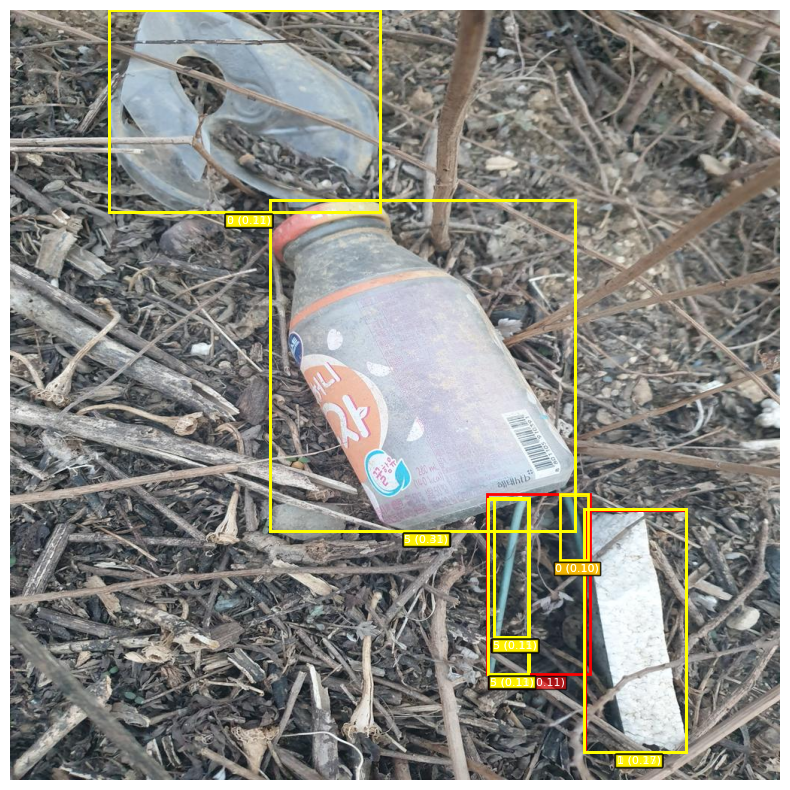

[(131.7491414835165,
  0,
  492.0164072039072,
  268.2613514957265,
  0.6110610961914062,
  5,
  0.8),
 (763.0416666666666,
  663.6058455433456,
  898.3766788766789,
  986.1020299145299,
  0.46775105595588684,
  6,
  0.8),
 (345.22954822954824,
  252.20951617826617,
  751.4089590964591,
  692.5343406593406,
  0.4455798864364624,
  3,
  0.8),
 (345.22954822954824,
  252.20951617826617,
  751.4089590964591,
  692.5343406593406,
  0.4406665563583374,
  4,
  0.8),
 (131.7491414835165,
  0,
  492.0164072039072,
  268.2613514957265,
  0.31277018785476685,
  3,
  0.8),
 (345.22954822954824,
  252.20951617826617,
  751.4089590964591,
  692.5343406593406,
  0.3052922487258911,
  5,
  0.8),
 (763.0416666666666,
  663.6058455433456,
  898.3766788766789,
  986.1020299145299,
  0.25316184759140015,
  0,
  0.8),
 (643.5687576312577,
  648.507554945055,
  688.5050366300367,
  832.8858363858363,
  0.2214631289243698,
  0,
  0.8),
 (635.7222985347985,
  648.8107448107448,
  689.5257936507936,
  882.360

In [73]:
model = RFDETRMedium(pretrain_weights="./RF_DETR_ckpt/checkpoint_best_ema.pth",resolution=768)

infer_multiscale_and_show(
    model,
    "../../../dataset_for_RFDETR/test/test/0001.jpg",
    scales=(0.8,1.0,1.3),
    threshold=0.1,
)

In [10]:

import pandas as pd
import numpy as np

def get_max_x2_y2(csv_path):
    df = pd.read_csv(csv_path)

    max_x2 = 0
    max_y2 = 0

    for pred in df["PredictionString"]:
        if isinstance(pred, float) and np.isnan(pred):
            continue
        
        tokens = pred.split()

        # 6개씩 끊어서 읽기: cls, score, x1, y1, x2, y2
        for i in range(0, len(tokens), 6):
            try:
                x2 = float(tokens[i+4])
                y2 = float(tokens[i+5])

                max_x2 = max(max_x2, x2)
                max_y2 = max(max_y2, y2)

            except:
                continue  # 혹시 누락된 값이 있으면 스킵

    return max_x2, max_y2


# 실행 예시
csv_path = "./output_TTA.csv"
max_x2, max_y2 = get_max_x2_y2(csv_path)

print("전체 박스 중 최대 x2:", max_x2)
print("전체 박스 중 최대 y2:", max_y2)

전체 박스 중 최대 x2: 1024.0
전체 박스 중 최대 y2: 1024.0


# output결과 이미지 저장 

In [5]:
import os
import cv2
import pandas as pd
import math
import numpy as np
from tqdm import tqdm 
class_name={0:"General trash", 1:"Paper", 2:"Paper pack", 3:"Metal", 4:"Glass", 5:"Plastic", 6:"Styrofoam", 7:"Plastic bag", 8:"Battery", 9:"Clothing"}
class_colors = {
    "0": (255, 0, 0),
    "1": (0, 255, 0),
    "2": (0, 0, 255),
    "3": (255, 255, 0),
    "4": (255, 0, 255),
    "5": (0, 255, 255),
    "6": (128, 0, 128),
    "7": (128, 128, 0),
    "8": (0, 128, 128),
    "9": (0, 128, 255),
}

In [6]:
CSV_PATH='../../D-FINE/dfine_submission.csv'
IMAGE_ROOT='../../../dataset/test/'
OUT_DIR='./predict_results'

os.makedirs(OUT_DIR, exist_ok=True)

In [7]:
df=pd.read_csv(CSV_PATH)

conf_threshold= 0.01

for idx, row in tqdm(df.iterrows(), total=len(df)):
    pred_str=row["PredictionString"]
    image_id=row["image_id"]
    # print(image_id)
    img_path=os.path.join(IMAGE_ROOT,image_id)
    # print(img_path)

    img=cv2.imread(img_path)


    tokens = pred_str.strip().split()
    # print(tokens)

    num_boxes=len(tokens)//6
    for i in range(num_boxes):
        label   = tokens[i * 6 + 0]
        score   = float(tokens[i * 6 + 1])
        x1      = float(tokens[i * 6 + 2])
        y1      = float(tokens[i * 6 + 3])
        x2      = float(tokens[i * 6 + 4])
        y2      = float(tokens[i * 6 + 5])

        if score>conf_threshold:
            
            x1_i, y1_i, x2_i, y2_i = map(int, [x1, y1, x2, y2])
            
            color = class_colors.get(label, (0, 255, 0))
            
            cv2.rectangle(img, (x1_i, y1_i), (x2_i, y2_i), color, 2)
            
            text = f"{class_name[int(label)]} {score:.2f}"
            (tw, th), baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
            
            cv2.rectangle(img, (x1_i, y1_i - th - baseline), (x1_i + tw, y1_i), color, -1)
            cv2.putText(
                img,
                text,
                (x1_i, y1_i - baseline),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (0, 0, 0),
                1,
                cv2.LINE_AA
            )
    out_filename = os.path.basename(image_id)
    out_path = os.path.join(OUT_DIR, out_filename)
    cv2.imwrite(out_path, img)

    

100%|███████████████████████████████████████████████████████████████████████████████| 4871/4871 [01:06<00:00, 72.92it/s]
